In [1]:
import netCDF4 as nc
import numpy as np

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial
from utils.db_tools import get_db, get_data

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
model = "bruss"
run_id = "dist2"


In [6]:
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
os.makedirs(output_dir, exist_ok=True)

df0 = get_db(data_dir, model)
df = df0[df0.run_id == run_id]
print(df.shape)

(800, 17)


In [7]:
distributions = []

for _, row in df.iterrows():
    filename = row['filename']
    sigma_ic_u = row['sigma_ic_u']
    sigma_ic_v = row['sigma_ic_v']
    seed = row['random_seed']

    data = get_data(row)
    final_u = data[0, -1, :, 0::2]
    final_v = data[0, -1, :, 1::2]

    N = row["Nx"]
    u_val = final_u[N//2, N//2]
    v_val = final_v[N//2, N//2]

    distributions.append({
        "sigma_ic_u": sigma_ic_u,
        "sigma_ic_v": sigma_ic_v,
        "u_val": u_val,
        "v_val": v_val,
        "seed": seed
    })

dist_df = pd.DataFrame(distributions)


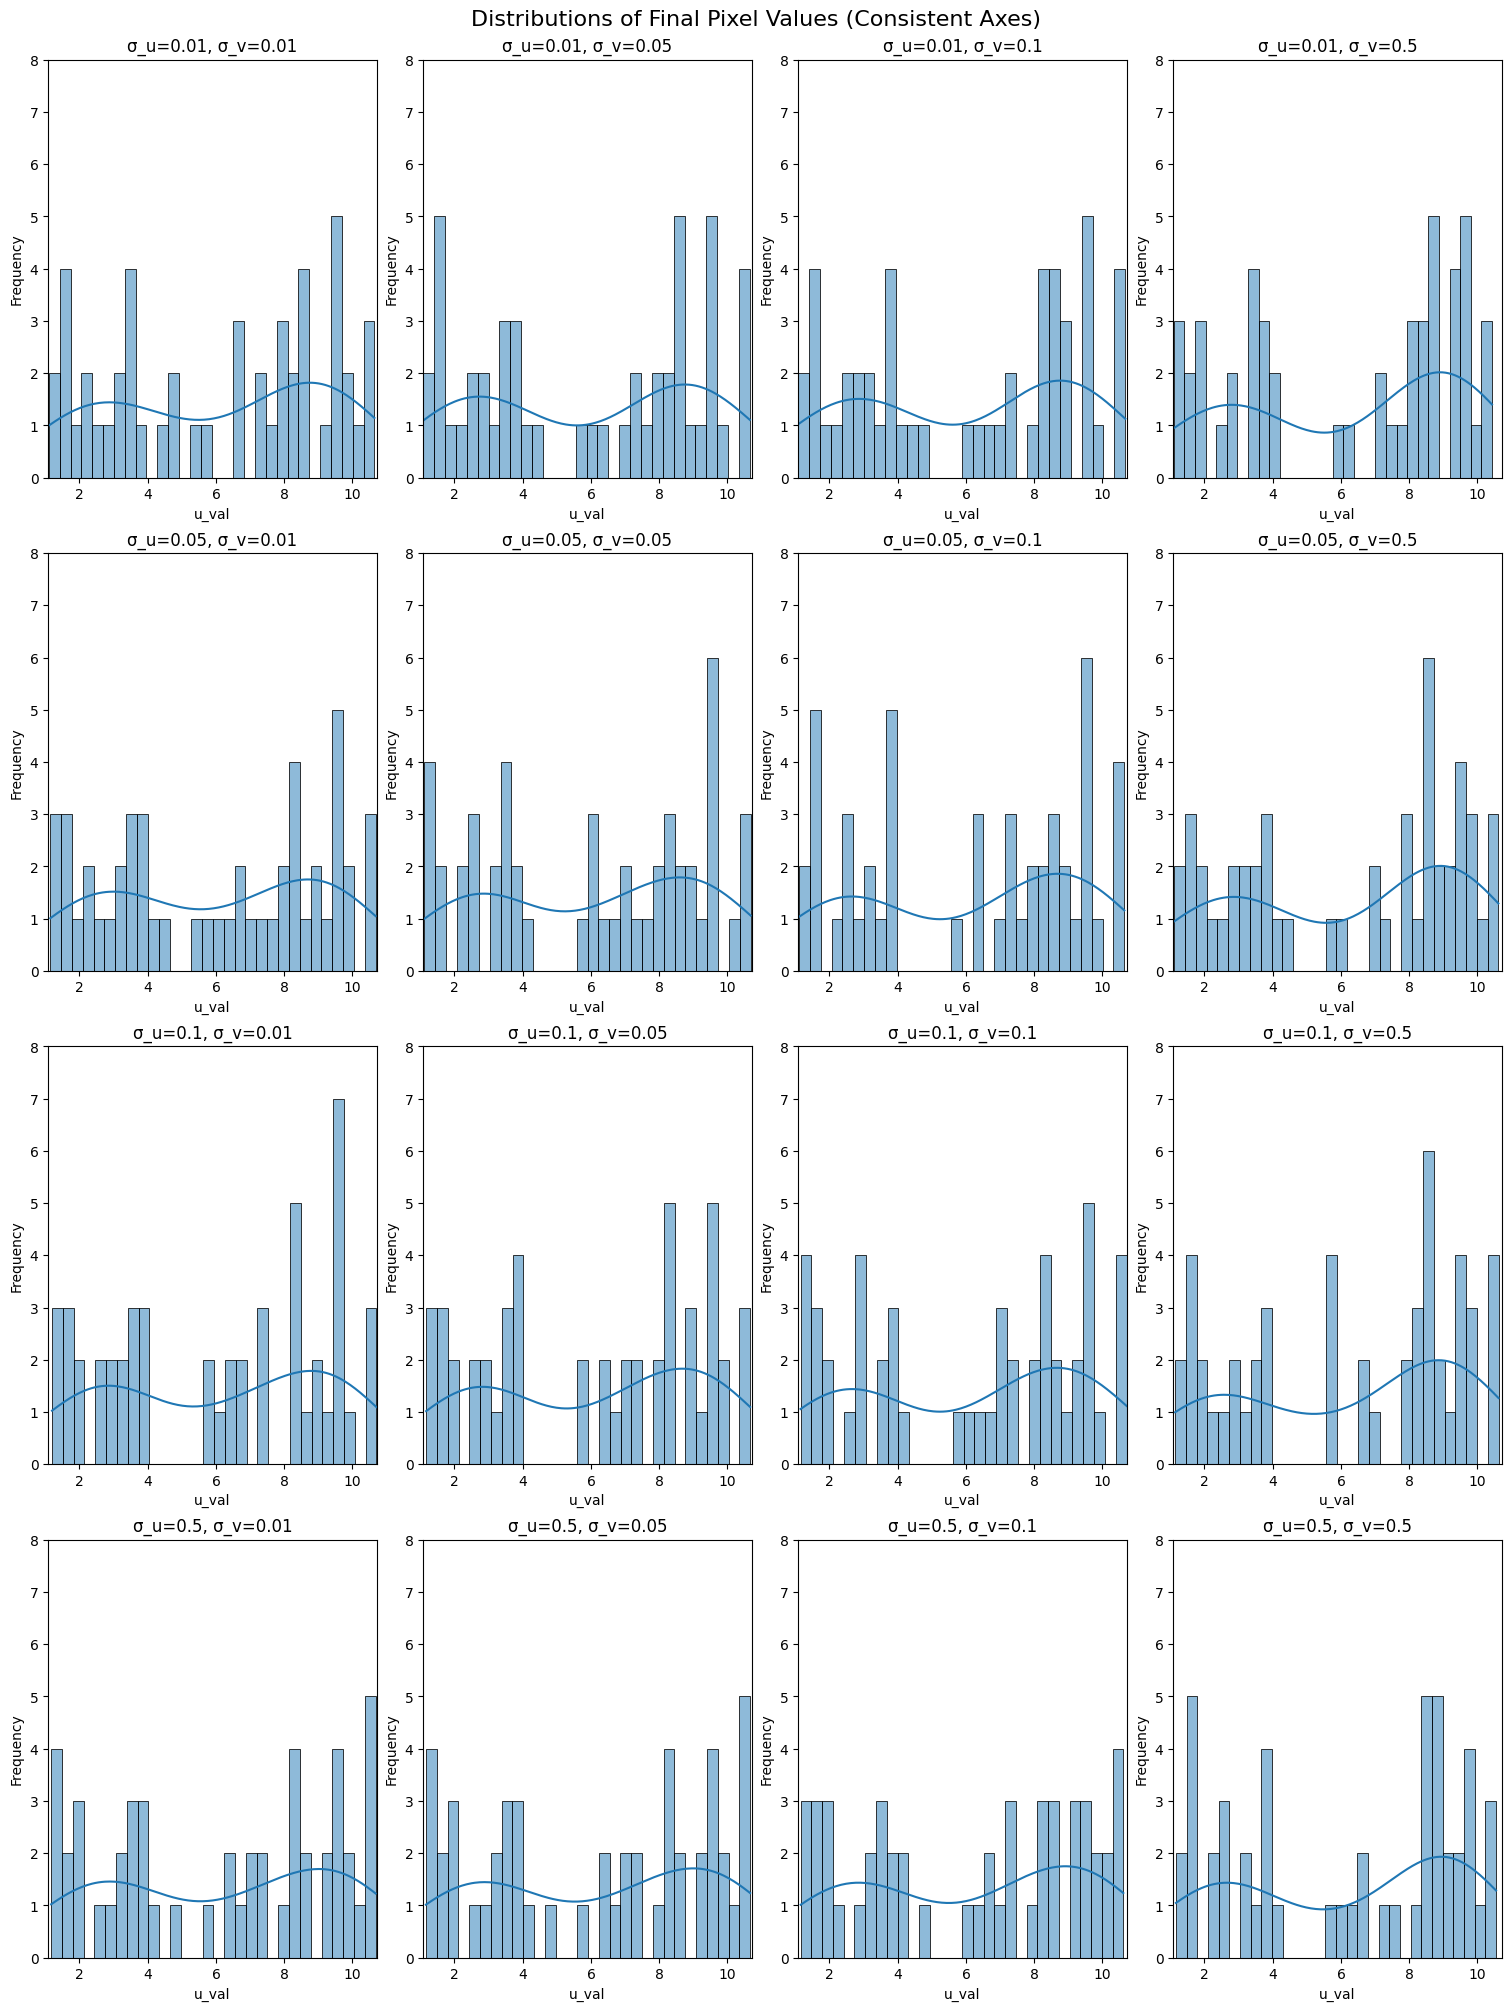

In [10]:
# Group by parameters
grouped = dist_df.groupby(["sigma_ic_u", "sigma_ic_v"])

# Determine grid size
num_groups = len(grouped)
n_cols = 4  # Number of columns
n_rows = (num_groups + n_cols - 1) // n_cols

all_values = dist_df["u_val"]
x_min, x_max = all_values.min(), all_values.max()

# Precompute global y limit by creating a histogram for all values
y_max = 0
for _, group in grouped:
    counts, _ = np.histogram(group["u_val"], bins=30, range=(x_min, x_max))
    y_max = max(y_max, counts.max())

# Create figure and axes
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True
)
axes = axes.flatten()

# Plot each group
for i, ((sigma_u, sigma_v), group) in enumerate(grouped):
    values = group["u_val"]
    ax = axes[i]

    # Plot histogram
    sns.histplot(values, kde=True, bins=30, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)
    ax.set_title(f"σ_u={sigma_u}, σ_v={sigma_v}")
    ax.set_xlabel("u_val")
    ax.set_ylabel("Frequency")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Set overall title
fig.suptitle("Distributions of Final Pixel Values (Consistent Axes)", fontsize=16)
plt.show()
